In [1]:
"""
Часть 1
Загрузка и очистка данных
"""

'\nЧасть 1\nЗагрузка и очистка данных\n'

In [529]:
#Импортируем необходимые для работы с данными библиотеки. Они понадобяться над в дальнейшем.
import pandas as pd
import numpy as np
import ast
import csv
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Flatten, Concatenate
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [288]:
#Открываем файл с данными, которые я предварительно собрал. Загружаем их.
df = pd.read_csv("output_file.csv")
df_games = pd.read_csv("output_file_games.csv")

In [4]:
"""
О сборе данных.
При сборе данных для проекта я столкнулся с некоторыми трудностями. Как я и планировал изначальна решено было собирать данные пользователей steam;
информацию об имеющихся у них играх, профиле, друзьям и тд. К сожалению базы данных стима, по очевидным причинам нету в открытом доступе. Моё обращение в 
steamdb по поводу предоставления части данных в учебных целях осталось без ответа.

У этой проблемы имелось два пути решения. Во первых была возможность обратиться к kaggle, там я смог обнаружить несколько любопытных датасетов, хоть 
и не полностью по моей теме. Усугубляла ситуацию, то что все они были выложенны давно, большая часть была просто многолетней давности, что в купе с неполностью
и разбробленностью создавало ряд потенциальных проблем в моём иследование. В связи с этим было принято решение scrapping самостоятельно через API.

Данных подход однако тоже был не без недостатков. Steam не предостовлял список из user_id, а по тому искать дополнительную информацию приходилось
почти в слепую, через друзей уже отработанного аккаунта. Такой метод был не удобен, а так же грозил подпортить dataset внося в него bias - ведь получиться, что 
скорее всего большинство данных будет из одного условного ксастера. В добавок API имел крайне ограниченный rate, следовательно сам процес сбора данных проходил
в крайне медленном темпе.

Алгоритм сбора можно описать так;
1.Подбираю валидный user_id
2.Удостовериваюсь в публичности аккаунта. Если нет обратно на 1 ступень.
3.Добавляю интересующею меня информацию в датасет
4.Смотрим на список друзей аккаунта. Добавляем их в импровизированую очередь.
5.Удостовериваюсь в публичности, если нет перехожу к следующему элементу в очереди.
6.Сохроняю информацию в датасет
7.Если очередь обрываеться/кончаеться/собираю достаточно много записей из одного кластера. Обратно на ступень 1
8.В противном случае продолжаем разбирать очередь
9.Повторяем неограниченно дролгое время, чем больше тем лучше.
"""

'\nО сборе данных.\nПри сборе данных для проекта я столкнулся с некоторыми трудностями. Как я и планировал изначальна решено было собирать данные пользователей steam;\nинформацию об имеющихся у них играх, профиле, друзьям и тд. К сожалению базы данных стима, по очевидным причинам нету в открытом доступе. Моё обращение в \nsteamdb по поводу предоставления части данных в учебных целях осталось без ответа.\n\nУ этой проблемы имелось два пути решения. Во первых была возможность обратиться к kaggle, там я смог обнаружить несколько любопытных датасетов, хоть \nи не полностью по моей теме. Усугубляла ситуацию, то что все они были выложенны давно, большая часть была просто многолетней давности, что в купе с неполностью\nи разбробленностью создавало ряд потенциальных проблем в моём иследование. В связи с этим было принято решение scrapping самостоятельно через API.\n\nДанных подход однако тоже был не без недостатков. Steam не предостовлял список из user_id, а по тому искать дополнительную инфор

In [5]:
#Посмотрим на характеристики датасета. Мало но в дальнейем можно сделать upscale и работаться с большим датасетом тем же образом
df.size, df.shape 

(97600, (9760, 10))

In [6]:
df.head(1)

,UserID,GamesOwned,name,picture,level,badge_total,current_xp,needed_xp,friends,error
0,76561198119601974,"[{'name': 'The Ship', 'appid': 2400, 'playtime...",naciskamprzyciski,https://avatars.steamstatic.com/fd4435caf17ed0...,17.0,10.0,2467.0,0.0,"['76561197972232134', '76561197972826786', '76...",NaN


In [7]:
#Избавимся от рядов в которые при scrappingге выдавали ошибку. (Проблема с rate от API)
df = df[df['error'].isna()]

In [8]:
df.isna().sum() #Теперь в датасете нет null values

UserID            0
GamesOwned        0
name              0
picture           0
level             0
badge_total       0
current_xp        0
needed_xp         0
friends           0
error          7273
dtype: int64

In [9]:
df.shape

(7273, 10)

In [10]:
#Издавимся от ссылок на картики. А также от error coloumn - так как они нам не нужны. 1 из-за отсутствие полезной информации. 2 из за дальнейшей ненадобности.
df.drop(columns=['error'], inplace=True)
df.drop(columns=['picture'], inplace=True)

In [11]:
#Заменим список из айдишников друзей на кол-во друзей. Айдишники ничего не дадут, а кол-во друзей потенциально интересный фактор.
friends = []
for i in range(0,df.shape[0]):
    temp = df.iloc[i]['friends']
    if (type(temp) != type(1)):
        lst = (temp.split(","))
    friends.append(len(lst)-1)

In [12]:
df['friends'] = friends

In [13]:
df

,UserID,GamesOwned,name,level,badge_total,current_xp,needed_xp,friends
0,76561198119601974,"[{'name': 'The Ship', 'appid': 2400, 'playtime...",naciskamprzyciski,17.0,10.0,2467.0,0.0,236
1,76561198334829575,"[{'name': 'Day of Defeat: Source', 'appid': 30...",IPshek,22.0,24.0,3705.0,0.0,72
2,76561198068831472,<Response [200]>,Vincent,0.0,0.0,0.0,0.0,0
3,76561198262231733,<Response [200]>,chssdk,30.0,21.0,6392.0,0.0,226
4,76561198164846731,"[{'name': 'Half-Life 2', 'appid': 220, 'playti...",HighTierHuman,47.0,67.0,13848.0,0.0,326
...,...,...,...,...,...,...,...,...
7521,76561199312850783,<Response [200]>,Pescemotto,0.0,0.0,0.0,0.0,2
7522,76561198140424528,<Response [200]>,Bruce Twarze,0.0,0.0,0.0,0.0,0
7523,76561198329909807,"[{'name': 'Neverwinter', 'appid': 109600, 'pla...",RiNo,11.0,10.0,1395.0,0.0,41
7524,76561198849488622,<Response [200]>,#Brian | Noel | ☩A.T.G☩-|,5.0,3.0,512.0,0.0,18


In [14]:
sum(df["GamesOwned"] == '<Response [200]>')

3747

In [15]:
#Для колоки games owned тоже сделаем featuere engeneering, во первых добавим в датасет кол-во самих игр. (Responce 200 -> игр нет)

In [16]:
friends = []
for i in range(0,df.shape[0]):
    temp = df.iloc[i]['GamesOwned']
    if (type(temp) != type(1)):
        lst = (temp.split(","))
    friends.append(len(lst)-1)
df['GamesOwnedNum'] = friends

In [17]:
temp = ['UserID', 'GamesOwned', 'GamesOwnedNum', 'name', 'level', 'badge_total', 'current_xp', 'needed_xp', 'friends']
df = df[temp]
df

,UserID,GamesOwned,GamesOwnedNum,name,level,badge_total,current_xp,needed_xp,friends
0,76561198119601974,"[{'name': 'The Ship', 'appid': 2400, 'playtime...",1760,naciskamprzyciski,17.0,10.0,2467.0,0.0,236
1,76561198334829575,"[{'name': 'Day of Defeat: Source', 'appid': 30...",622,IPshek,22.0,24.0,3705.0,0.0,72
2,76561198068831472,<Response [200]>,0,Vincent,0.0,0.0,0.0,0.0,0
3,76561198262231733,<Response [200]>,0,chssdk,30.0,21.0,6392.0,0.0,226
4,76561198164846731,"[{'name': 'Half-Life 2', 'appid': 220, 'playti...",1415,HighTierHuman,47.0,67.0,13848.0,0.0,326
...,...,...,...,...,...,...,...,...,...
7521,76561199312850783,<Response [200]>,0,Pescemotto,0.0,0.0,0.0,0.0,2
7522,76561198140424528,<Response [200]>,0,Bruce Twarze,0.0,0.0,0.0,0.0,0
7523,76561198329909807,"[{'name': 'Neverwinter', 'appid': 109600, 'pla...",338,RiNo,11.0,10.0,1395.0,0.0,41
7524,76561198849488622,<Response [200]>,0,#Brian | Noel | ☩A.T.G☩-|,5.0,3.0,512.0,0.0,18


In [18]:
df.iloc[1]['GamesOwned'] #Для работой с такой структурой данных создадим стуруктуру похожую на ту, что была в ML-проекте на курсе. То есть
#пользователь - игра - доп имформация о пользоватете.
"""
К примеру если было 
user_id, games_owned, xp_level
user1 (minecraft, csgo), 5 

То станет
user1 minecraft 5
user1 csgo 5
"""

'\nК примеру если было \nuser_id, games_owned, xp_level\nuser1 (minecraft, csgo), 5 \n\nТо станет\nuser1 minecraft 5\nuser1 csgo 5\n'

In [110]:
import ast
import pandas as pd

df_new = pd.DataFrame(columns=[
    'UserID', 'app_ids', 'playtime', 'games_owned_num', 'name', 
    'level', 'badge_total', 'current_xp', 'needed_xp', 'friends'
])
for i in range(df.shape[0]):
    val = df.iloc[i]['GamesOwned']
    if (val[0] != '['):
        games = []
    else:    
        games = val.strip("[]").split("}, {")
    temp_lst = []
    temp_lst1 = []
    for el in games:
        if (el[0] != '{'): #Фиксим структуру в крайних случаях
            el = "{" + el
        if (el[-1] != '}'):
            el = el + '}'
        el = ast.literal_eval(el)
        temp_lst.append((el['appid']))
        temp_lst1.append((el['playtime_forever']))
    newrow = [
                str(df.iloc[i]['UserID']),     
                temp_lst,            
                temp_lst1,            
                df.iloc[i]['GamesOwnedNum'],       
                df.iloc[i]['name'],                 
                df.iloc[i]['level'],           
                df.iloc[i]['badge_total'],        
                df.iloc[i]['current_xp'],         
                df.iloc[i]['needed_xp'],        
                df.iloc[i]['friends']            
            ]
            
    df_new.loc[len(df_new)] = newrow



In [111]:
df_new.head()

,UserID,app_ids,playtime,games_owned_num,name,level,badge_total,current_xp,needed_xp,friends
0,76561198119601974,"[2400, 2420, 2430, 20900, 9480, 17460, 16720, ...","[364, 0, 0, 0, 0, 0, 0, 265, 0, 0, 27, 0, 0, 8...",1760,naciskamprzyciski,17.0,10.0,2467.0,0.0,236
1,76561198334829575,"[300, 20, 280, 360, 1200, 1230, 1280, 320, 340...","[20, 64, 524, 0, 311, 0, 54, 105, 29, 68, 76, ...",622,IPshek,22.0,24.0,3705.0,0.0,72
2,76561198068831472,[],[],0,Vincent,0.0,0.0,0.0,0.0,0
3,76561198262231733,[],[],0,chssdk,30.0,21.0,6392.0,0.0,226
4,76561198164846731,"[220, 340, 4000, 12120, 12250, 23310, 7860, 12...","[190, 0, 308, 35, 0, 0, 0, 332, 0, 204, 789, 0...",1415,HighTierHuman,47.0,67.0,13848.0,0.0,326


In [183]:
df_new.shape
unique_app_ids = set([i for el in df_new['app_ids'] for i in el])
print(len(unique_app_ids))

39739


In [184]:
#Мы загрузили данные, и подготовили из к работе. У нас есть два датафрейма. Один (df) для дальнейшего анализа, другой же
#df_new будет использоваться для работы с моделью. Далее соберём и подготовим аналогичным образом информацию по играм.

In [23]:
"""
Часть 2 анализ данных
"""

'\nЧасть 2 анализ данных\n'

In [24]:
#Посмотрим основные статистики. Сразу можем увидить mean и standart deviation наших столбцов. Как мы видим распределение игр очень не равномерно. 
#Standart deviation огромен. Это необзодимо будет учитывать в дальнейнем. Аналогично и с уровнями пользователей и большеинства он маленький но есть
#outliars с очень поьшими значениями.
#
#
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
Index: 7273 entries, 0 to 7525
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   UserID         7273 non-null   int64  
 1   GamesOwned     7273 non-null   object 
 2   GamesOwnedNum  7273 non-null   int64  
 3   name           7273 non-null   object 
 4   level          7273 non-null   float64
 5   badge_total    7273 non-null   float64
 6   current_xp     7273 non-null   float64
 7   needed_xp      7273 non-null   float64
 8   friends        7273 non-null   int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 568.2+ KB
None
             UserID  GamesOwnedNum        level   badge_total    current_xp  \
count  7.273000e+03    7273.000000  7273.000000   7273.000000  7.273000e+03   
mean   7.656120e+16     447.770521    25.572254     41.952014  2.097114e+04   
std    3.641151e+08    2764.157762    56.943882    348.252516  2.602745e+05   
min    7.656120e+16       0.00

In [25]:
#У нас есть предстовление по поквартальному расспределению, но это не вся возможная информация, ведь мы можем построиться более подробные графики

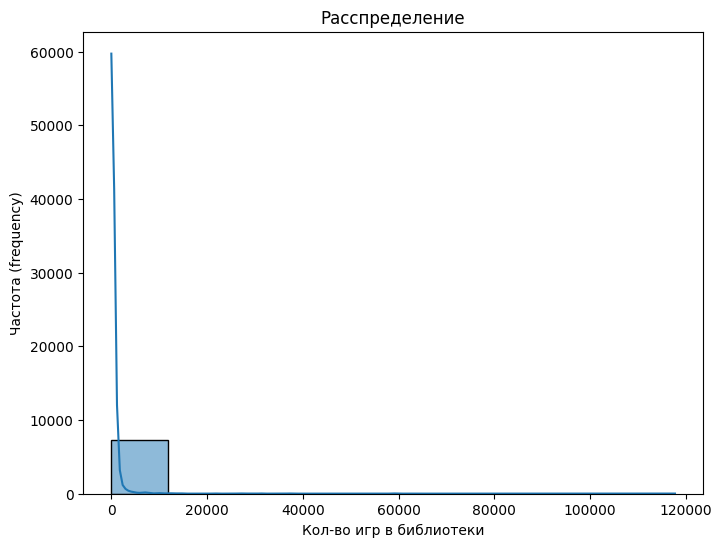

Пользователи с самым большим кол-во игр:
           name  GamesOwnedNum
7500     Sonix         117717
2440  xrain_cc          69000
4391    JohCar          62021
6705     tbone          59407
3331      A dJ          59126


In [26]:
plt.figure(figsize=(8, 6))
sns.histplot(df['GamesOwnedNum'], bins=10, kde=True)
plt.title('Расспределение')
plt.xlabel('Кол-во игр в библиотеки')
plt.ylabel('Частота (frequency)')
plt.show()

top_games_users = df[['name', 'GamesOwnedNum']].sort_values(by='GamesOwnedNum', ascending=False).head(5)
print("Пользователи с самым большим кол-во игр:\n", top_games_users) #эти аутлаеры надо сбросить для лучшего графика

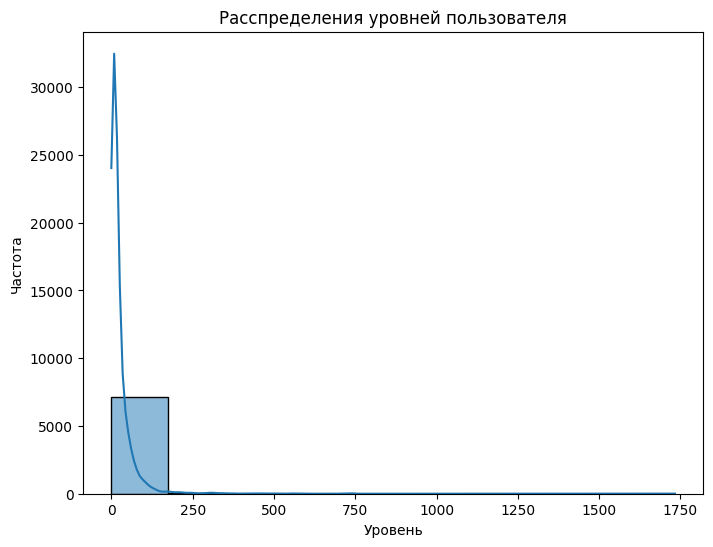

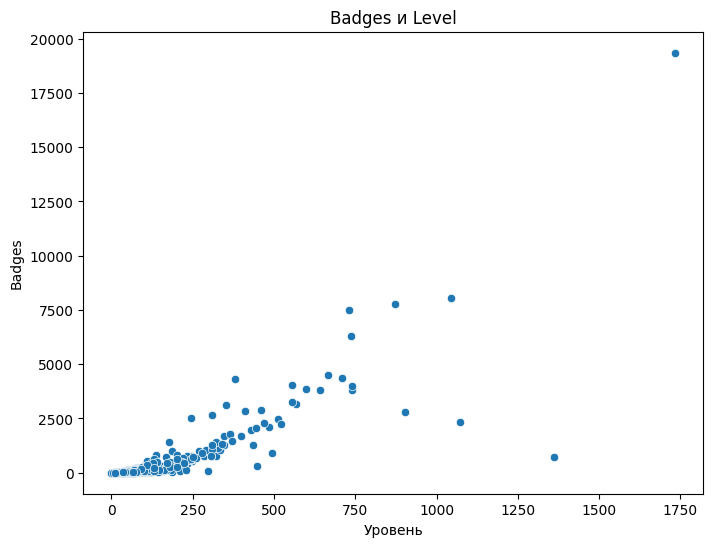

In [27]:
plt.figure(figsize=(8, 6))
sns.histplot(df['level'], bins=10, kde=True)
plt.title('Расспределения уровней пользователя')
plt.xlabel('Уровень')
plt.ylabel('Частота')
plt.show()

# Badge distribution vs Level
plt.figure(figsize=(8, 6))
sns.scatterplot(x='level', y='badge_total', data=df)
plt.title('Badges и Level')
plt.xlabel('Уровень')
plt.ylabel('Badges')
plt.show()

In [28]:
"""
1.Расспределение по уровням похоже на расспределение по кол-во игр, такое же не равномерное. Имееться резкий подъем в начале, так как 
при самом небольшом использование (покупки игры) уровень повышаеться хотябы до 1.
2.Очевидна корреляция между уровнем и badges. По крайней мере на начальных этапах.
"""

'\n1.Расспределение по уровням похоже на расспределение по кол-во игр, такое же не равномерное. Имееться резкий подъем в начале, так как \nпри самом небольшом использование (покупки игры) уровень повышаеться хотябы до 1.\n2.Очевидна корреляция между уровнем и badges. По крайней мере на начальных этапах.\n'

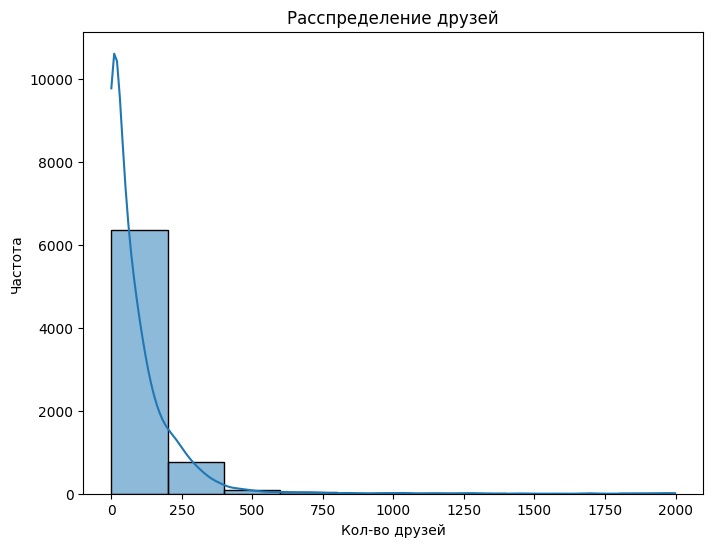

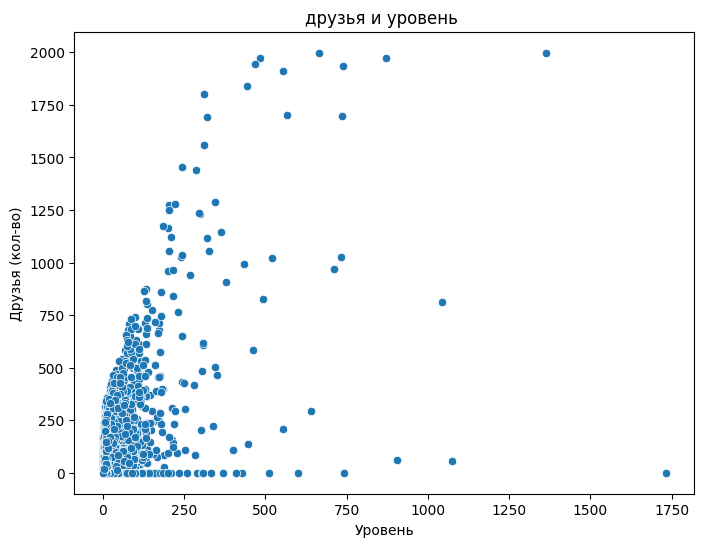

In [29]:
#Расспределение друзей
plt.figure(figsize=(8, 6))
sns.histplot(df['friends'], bins=10, kde=True)
plt.title('Расспределение друзей')
plt.xlabel('Кол-во друзей')
plt.ylabel('Частота')
plt.show()

#Скаттерплот друзья и уровень 
plt.figure(figsize=(8, 6))
sns.scatterplot(x='level', y='friends', data=df)
plt.title('друзья и уровень ')
plt.xlabel('Уровень')
plt.ylabel('Друзья (кол-во)')
plt.show()

In [30]:
#Расспределение друзей крайне skewed to the left. Знакомый нам уже характер расспределения.
#В случае уровень вс друзья. Расспеределение любопытно. Прослеживаються 2 тренда - очень высокоуровневые игроки, но без/мало друзей. И относительно
#низко уровневые но много друзей. Можно в дальнейшем стративицировать пользователей. Проведём условную линию по графику (под 45 градусов). Все
#кто над линией кластер экстровертов, под интровертов. Можно будет в дальнейшем реккомендовать им в соответсвтие с этим.

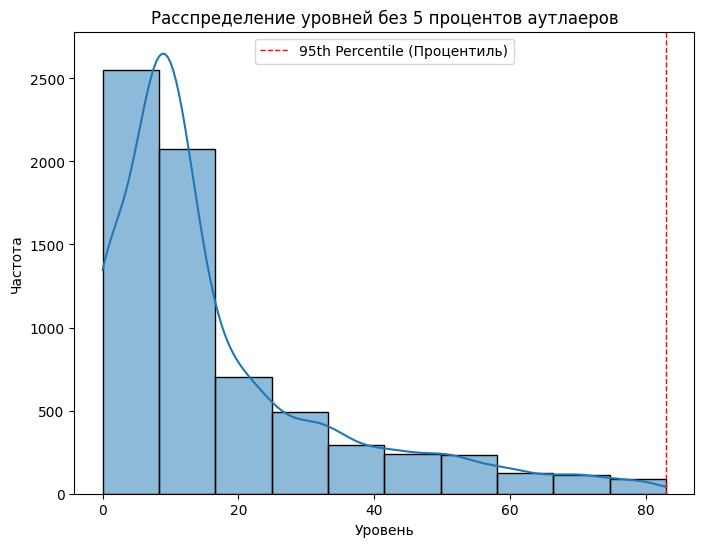

In [31]:
#Вернёмся к расспределению уровней. Уберём 5 процентов аутлаеров.
level_95th_percentile = df['level'].quantile(0.95)
filtered_df = df[df['level'] <= level_95th_percentile]

plt.figure(figsize=(8, 6))
sns.histplot(filtered_df['level'], bins=10, kde=True)
plt.title('Расспределение уровней без 5 процентов аутлаеров')
plt.xlabel('Уровень')
plt.ylabel('Частота')
plt.axvline(level_95th_percentile, color='red', linestyle='dashed', linewidth=1, label='95th Percentile (Процентиль)')
plt.legend()
plt.show()

In [32]:
#Теперь расспределения большинства значаний видно лучше!

In [33]:
#Но игроки это не единственная важная для нас информация рассмортрим также данные самих игр.

In [370]:
df_games = pd.read_csv("output_file_games.csv")
df_games.head()

,name,steam_appid,description,release_date,developers,publishers,genres,price
0,Aftermath Y2K,655360,Inspired by such games as Castlevania and Ninj...,"10 Jul, 2017","['Matthew Willis', 'Jesse Crespo']",['Matthew Willis'],"['Action', 'Indie']","3,99€"
1,Super Man Or Monster,393220,Super Man Or Monster is an explosive monsterfi...,"31 Oct, 2017",['Xform'],['Xform'],"['Action', 'Adventure', 'Indie']","12,99€"
2,Terje Haakonsen's Powder VR,1048580,"Master the mountain from 14,000 ft in this ext...","16 Dec, 2020",['RainSoft'],['RainSoft'],"['Casual', 'Indie', 'Racing', 'Simulation', 'S...","16,79€"
3,Vanguard Princess,262150,Vanguard Princess is a classic 2D fighting gam...,"3 Mar, 2014",['Tomoaki Sugeno'],['eigoMANGA'],"['Action', 'Casual', 'Indie']","4,99€"
4,Counter-Strike,10,Сыграйте в лучший онлайновый экшен в мире. При...,1 ноя. 2000 г.,['Valve'],['Valve'],['Экшены'],169₴


In [371]:
df_games.isna().sum()

name            1
steam_appid     0
description     1
release_date    0
developers      0
publishers      0
genres          0
price           0
dtype: int64

In [372]:
print(df_games.info())
print(df_games.describe())
print(df_games.shape) #Базовая информация, как видим пропусков нет, за исключением release date, но и там всего 4 пропуска. Датасет небольшой из-за проблем со скрапингом но в последующем его можно будет аналогично нарастить

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1160 entries, 0 to 1159
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   name          1159 non-null   object
 1   steam_appid   1160 non-null   int64 
 2   description   1159 non-null   object
 3   release_date  1160 non-null   object
 4   developers    1160 non-null   object
 5   publishers    1160 non-null   object
 6   genres        1160 non-null   object
 7   price         1160 non-null   object
dtypes: int64(1), object(7)
memory usage: 72.6+ KB
None
        steam_appid
count  1.160000e+03
mean   8.766184e+05
std    6.928736e+05
min    1.000000e+01
25%    3.949300e+05
50%    6.575550e+05
75%    1.182508e+06
max    3.017120e+06
(1160, 8)


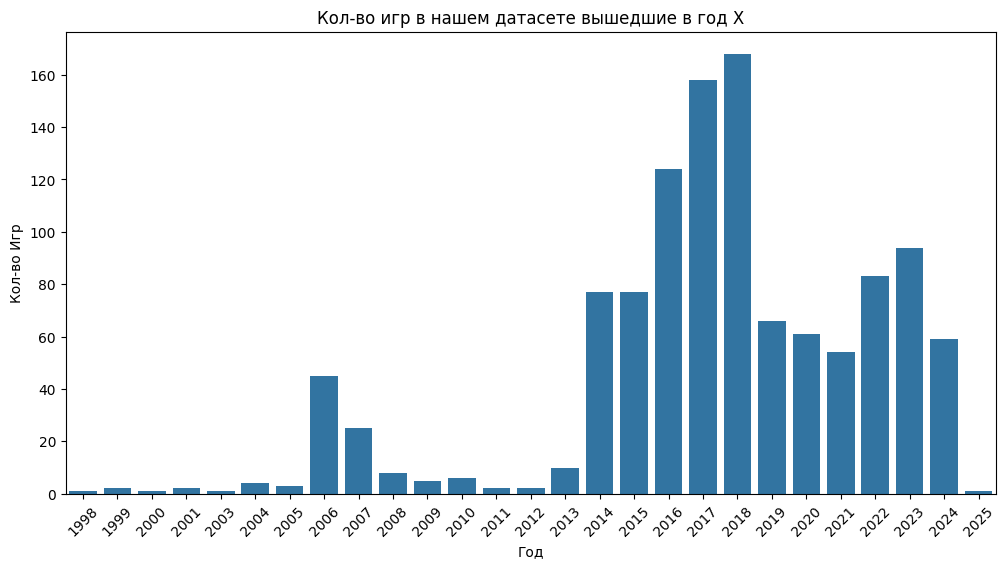

In [373]:
plt.figure(figsize=(12, 6))
df_games['release_date'] = pd.to_datetime(df_games['release_date'], errors='coerce') #исправим формат даты и цены
df_games = df_games.dropna(subset=['release_date'])

sns.countplot(data=df_games, x=df_games['release_date'].dt.year)

plt.xticks(rotation=45)
plt.title('Кол-во игр в нашем датасете вышедшие в год Х')
plt.xlabel('Год')
plt.ylabel('Кол-во Игр')
plt.show()

In [374]:
#Рассмотрим выход игр по годам. Виден 1 небольшой пик в районе 2006 года. Потом в 17-18 годах. Далее сильный спад за 19-21 года. В послековидное вермя возобновляеться рост.
#Стоить отметить, что в библиотеках имеються игры которые выйдут только в 2025 году - это демо версии к будущим играм уже вышедшие в магазин.

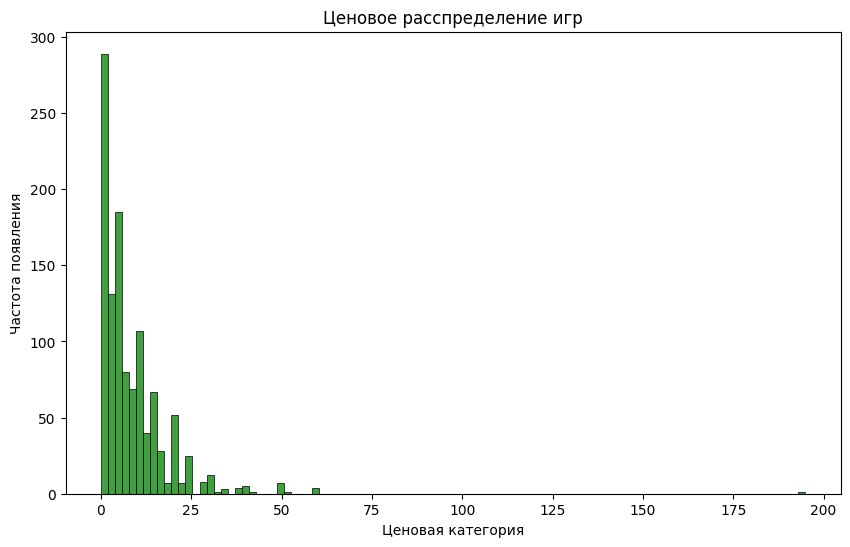

In [375]:
#Теперь посмотрим цены
df_games['price'] = df_games['price'].replace({'€': '', '': ''}, regex=True) 
df_games['price'] = df_games['price'].replace({',': '.', '': ''}, regex=True) 
df_games['price'] = df_games['price'].replace({'Free': '0', '': ''}, regex=True) 

df_games['price'] = pd.to_numeric(df_games['price'], errors='coerce')
df_games = df_games.dropna(subset=['price'])
df_games['price'] = df_games['price'].astype(float)

plt.figure(figsize=(10, 6))

sns.histplot(df_games['price'].sort_values(), bins=100, kde=False, color='green')
plt.title('Ценовое расспределение игр')
plt.xlabel('Ценовая категория')
plt.ylabel('Частота появления')
plt.show()

In [376]:
#Как мы видим у пользователей в библиотеке превалируют бесплатные/дешёвые игры. Игр которые стоят больше 50 долларов практически нет.
#Нектаря неравномерсть расспределения обусловленна наличием "популярных ценовых категорий," такие как, 1.99 2.99 4.99 9.99 19.99 49.99

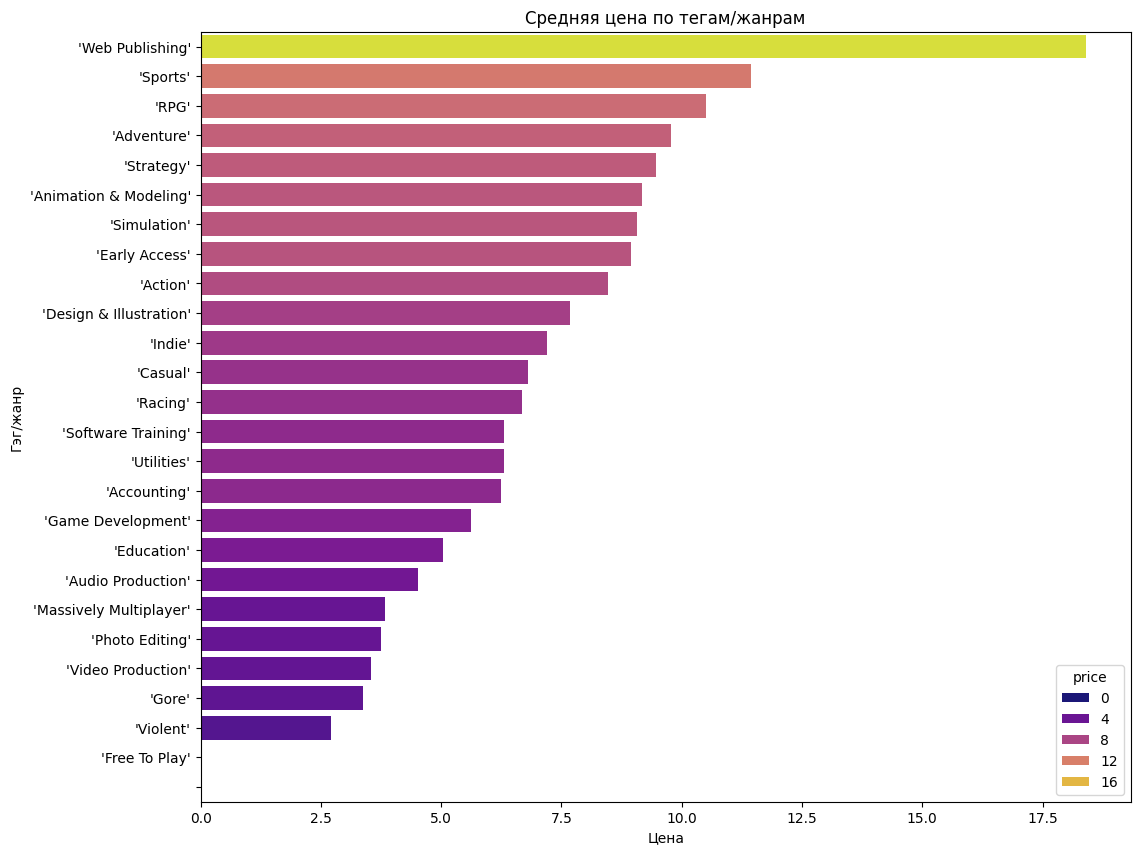

In [380]:
df_my = df_games.copy()

df_my['genres'] = df_games['genres'].apply(lambda x: x[1:-1].split(', '))

genres_exploded = df_my.explode('genres')
avg_price_by_genre = genres_exploded.groupby('genres')['price'].mean().reset_index()

plt.figure(figsize=(12, 10))
sns.barplot(data=avg_price_by_genre.sort_values('price', ascending=False), x='price', y='genres', palette='plasma', hue = 'price')
plt.title('Средняя цена по тегам/жанрам')
plt.xlabel('Цена')
plt.ylabel('Гэг/жанр')
plt.show()

In [ ]:
#Как мы видим самые дорогие игры принадлежат самиздату. Так же спортивные игры, РПГ, приключения и стратегии являються в среднем более дорогие нежеле другие части рынка,
#Free to play игры бесплатные, что в принципе очевидно. Нигде средняя цена не превылила 20 долларов.

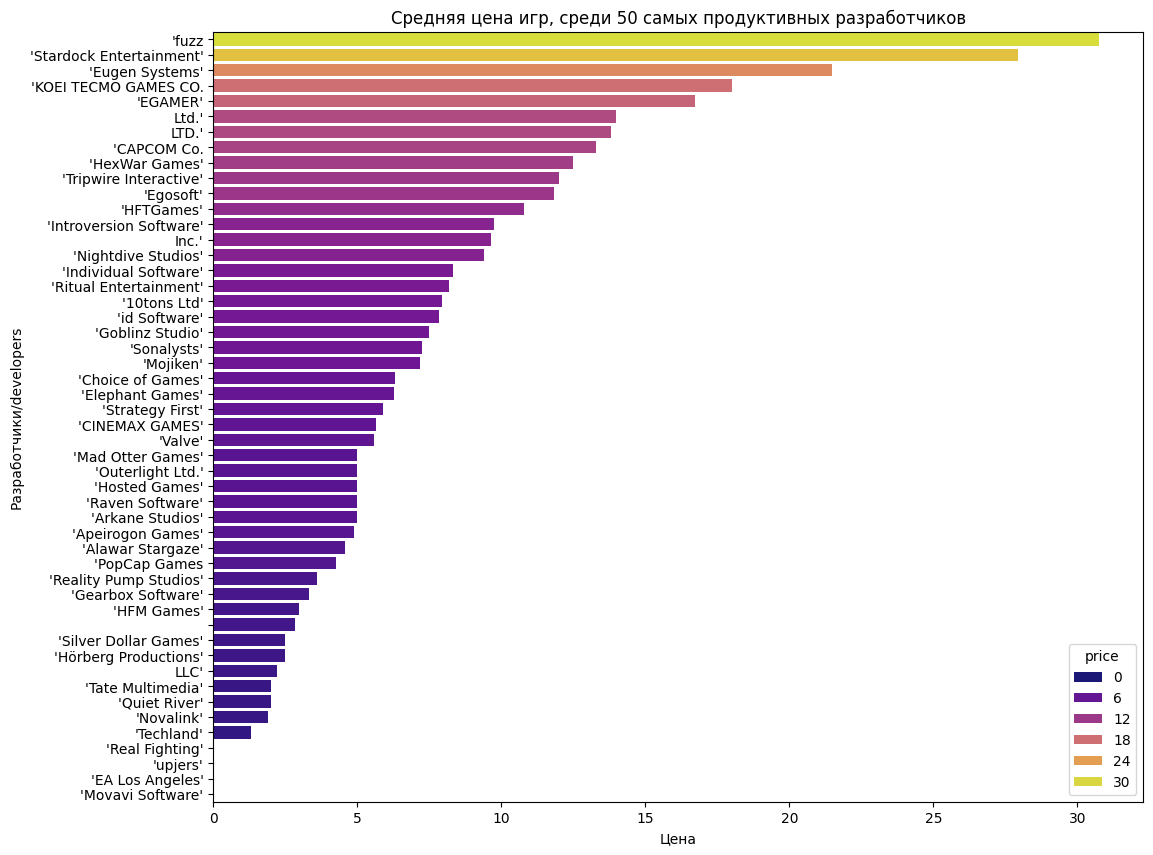

In [389]:
df_my = df_games.copy()

df_my['developers'] = df_games['developers'].apply(lambda x: x[1:-1].split(', '))

genres_exploded = df_my.explode('developers')
avg_price_by_genre = genres_exploded.groupby('developers')['price'].mean().reset_index()

developer_counts = genres_exploded['developers'].value_counts().reset_index() #по продуктивности
developer_counts.columns = ['developers', 'count']
top_developers = developer_counts.head(50)['developers'] #50 самых "продуктивных" издателей, можно больше но тогда график сложно будет рассмотреть

temp = genres_exploded[genres_exploded['developers'].isin(top_developers)]
avg_price_by_top_developers = temp.groupby('developers')['price'].mean().reset_index()

# Step 5: Plot the chart
plt.figure(figsize=(12, 10))
sns.barplot(data=avg_price_by_top_developers.sort_values('price', ascending=False), 
            x='price', y='developers', palette='plasma', hue='price')

plt.title('Средняя цена игр, среди 50 самых продуктивных разработчиков')
plt.xlabel('Цена')
plt.ylabel('Разработчики/developers')
plt.show()
#Как мы можем убедиться распределение напоминает гиперболу. По большей части разработчики не ставят цену больше 50$

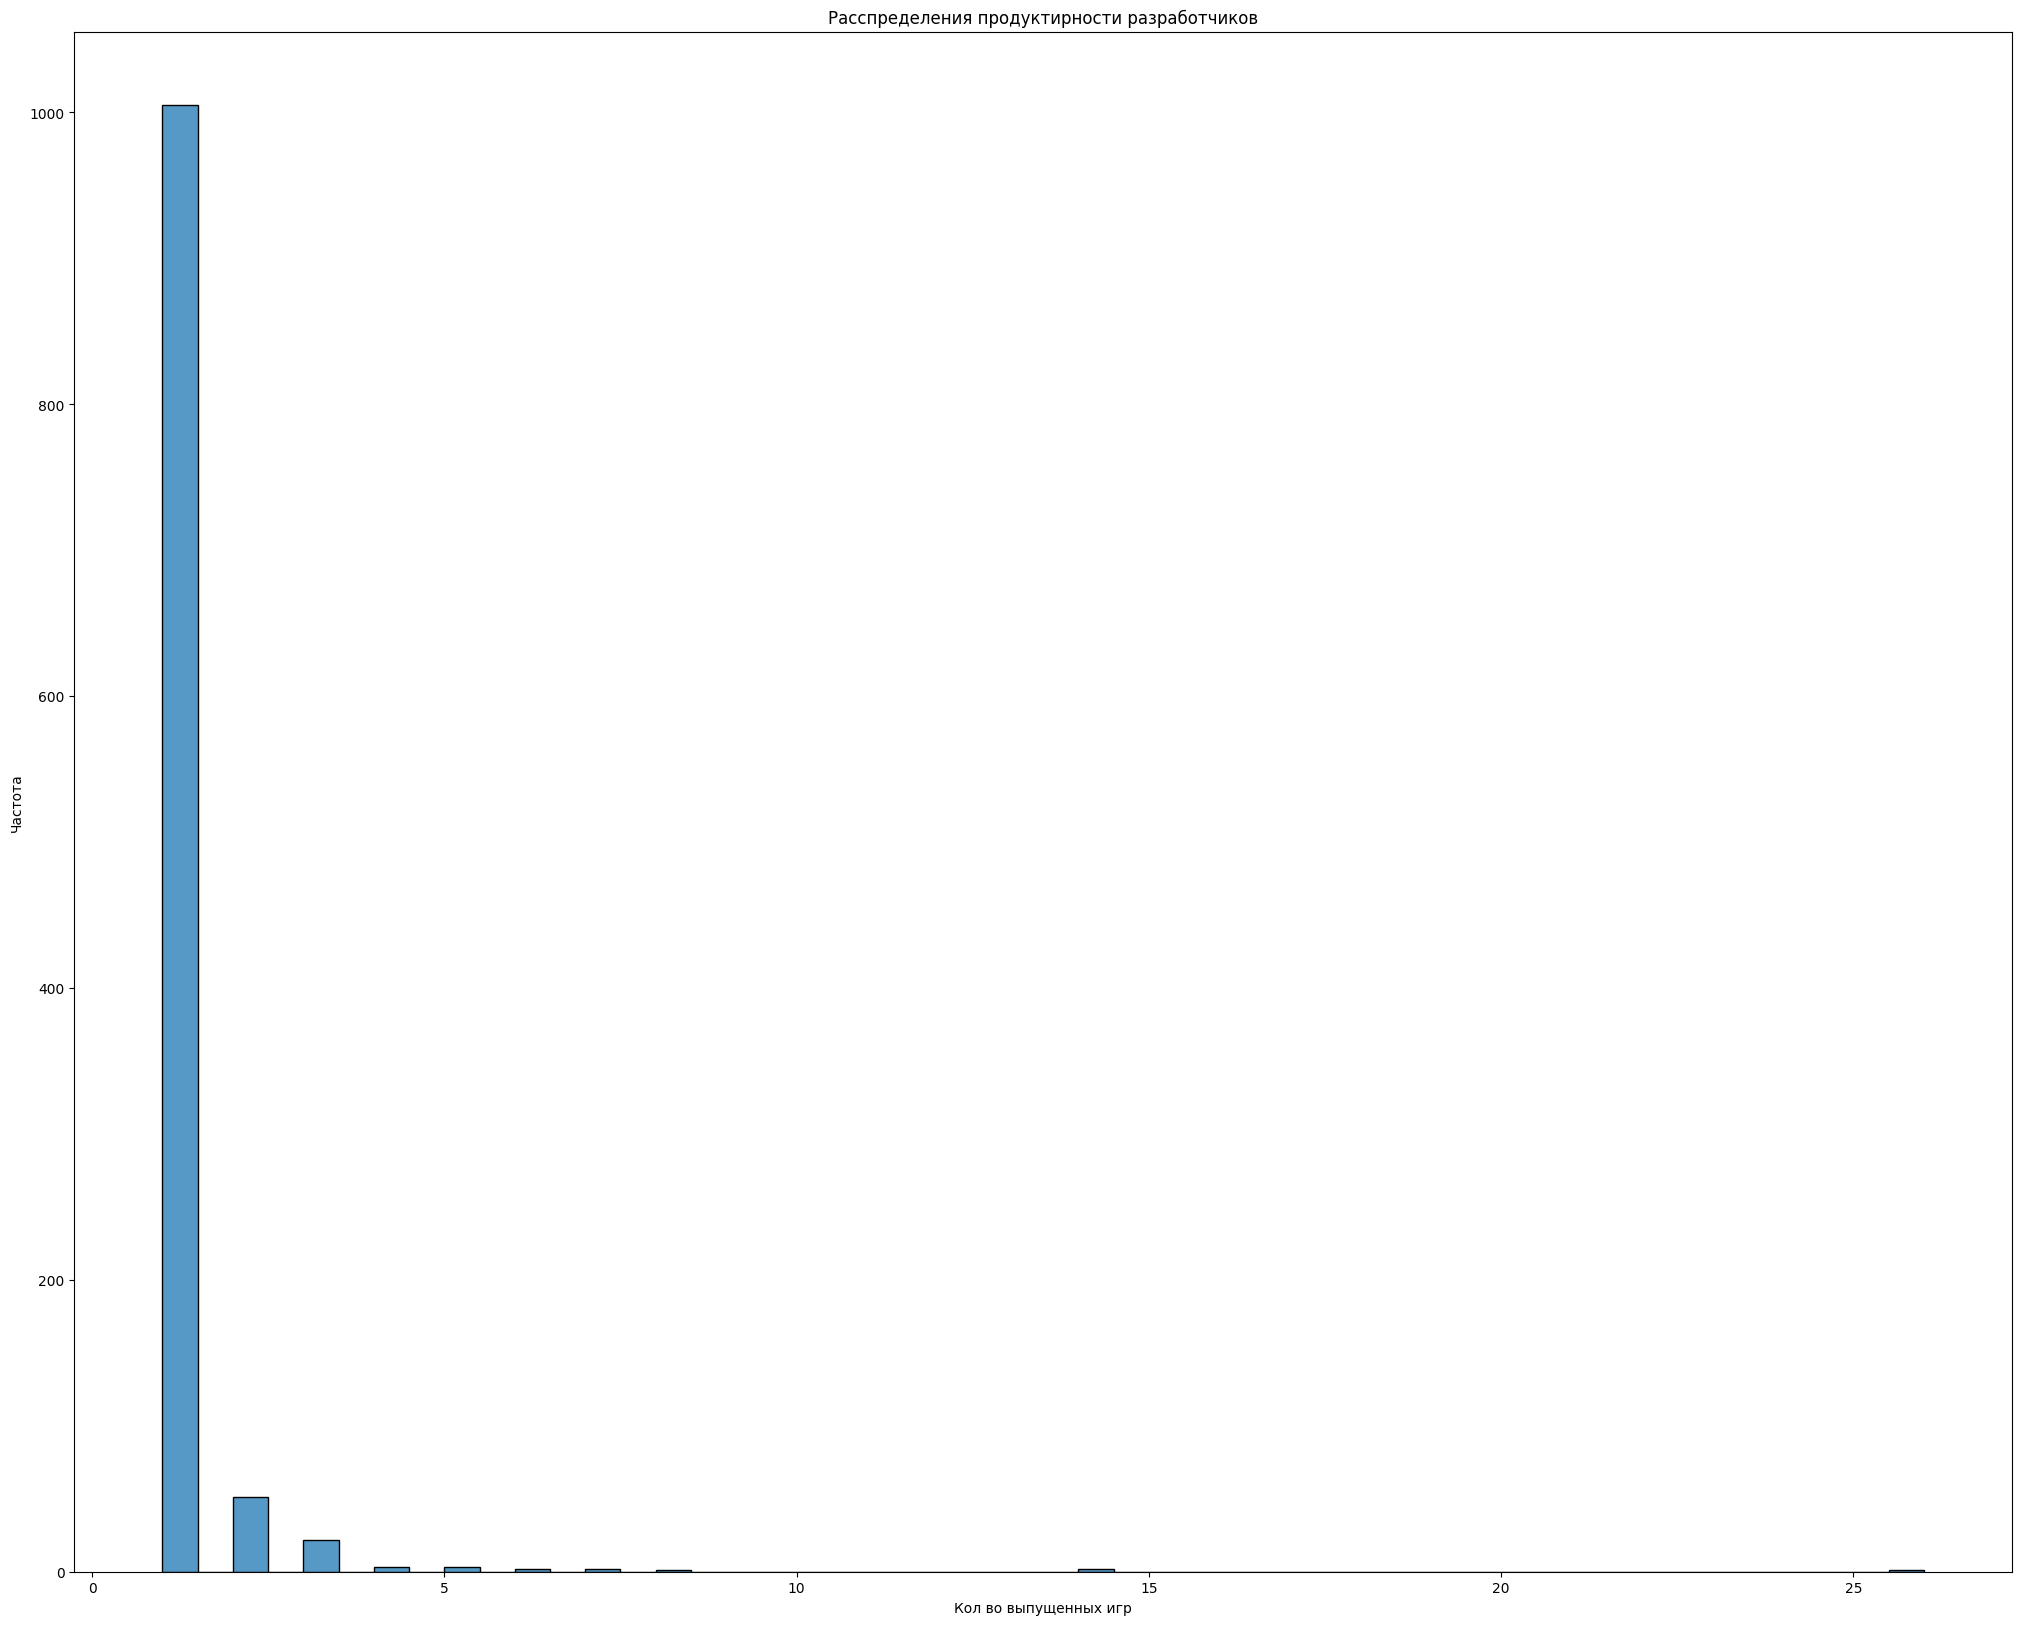

In [395]:
#Посмотрим на расспределение продуктивности отдельных разработчиков

plt.figure(figsize=(25, 20))
sns.histplot(developer_counts['count'], bins=50, kde=False)
plt.title('Расспределения продуктирности разработчиков')
plt.xlabel('Кол во выпущенных игр')
plt.ylabel('Частота')
plt.show() #Как видим большинство издателей создали только 1 игру.

In [102]:
"""
Часть 3 модели
Рассмотрим 2 возможных фундаментальных подхода. Суть первого подхода заключаеться в векторном представление игры. Далее смотрим какие игры нравяться пользователю
х нравяться игры и рекомендуем похожие. Это интересный подход, но он имеет ряд серьёзных недостатков, например и главным образам игрокам часто нраявться изменения
допусти у игрока онди стратегие в библиотеки, но они ему надоели и он хочет попробовать новые жанры, но не знает что взять, в этом случае наше решение будеть практически бессильно
так как оно вряди сможет определить, что у пользователя выгорание и ему нужно предпологать необычние игры. Способ обхода этой проблемы есть - 
мы всего навсего в списке из 5 рекомендаций будем предлогать случайную игру на выбор.

Второй подход подобен подходу бывшему в финальном проекте по модулям. Мы объеденим игры и пользователе в одну таблицу и будет работать с ней.
Возможно сделать простенькую модель с Catboost-ом а паработав ещё с данными загрузить данные в keras.
"""
df_new.shape

(7273, 10)

In [181]:
df_new.head()

,UserID,app_ids,playtime,games_owned_num,name,level,badge_total,current_xp,needed_xp,friends
0,76561198119601974,"[2400, 2420, 2430, 20900, 9480, 17460, 16720, ...","[364, 0, 0, 0, 0, 0, 0, 265, 0, 0, 27, 0, 0, 8...",1760,naciskamprzyciski,17.0,10.0,2467.0,0.0,236
1,76561198334829575,"[300, 20, 280, 360, 1200, 1230, 1280, 320, 340...","[20, 64, 524, 0, 311, 0, 54, 105, 29, 68, 76, ...",622,IPshek,22.0,24.0,3705.0,0.0,72
2,76561198068831472,[],[],0,Vincent,0.0,0.0,0.0,0.0,0
3,76561198262231733,[],[],0,chssdk,30.0,21.0,6392.0,0.0,226
4,76561198164846731,"[220, 340, 4000, 12120, 12250, 23310, 7860, 12...","[190, 0, 308, 35, 0, 0, 0, 332, 0, 204, 789, 0...",1415,HighTierHuman,47.0,67.0,13848.0,0.0,326


In [186]:
#1 простая модель. Суть. Представляем каждого пользователя в виде вектора. Ищем наиболее похожих пользователей
#Как метрику дистанции используем cosine simularity. Далее смотрим какие игры есть у похожих пользователей, а у нашего пользователя нет.
#Игры которые есть у похожих пользователей но нет у заданного пользователя и будут рекомендовыны (топ по плейтайму)

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler

class Recommender:
    def __init__(self, users_data):
        """
        Смысл данного класса будет 
        """
        self.users_data = users_data
        self.user_index = {user['UserID']: user for user in users_data}
        self.user_ids, self.numerical_vectors, self.app_id_playtime_vectors = self._vectorize_users(users_data)
        self.all_user_vectors = np.hstack([self.numerical_vectors, self.app_id_playtime_vectors])
    
    def _vectorize_users(self, users_data):
        """
        Конвертируем данные о пользователях в векторы
        """
        user_ids = []
        numerical_data = []
        app_ids_data = []
        playtime_data = []

        item_ids = set([app_id for user in users_data for app_id in user['app_ids']])
        item_id_index = {app_id: idx for idx, app_id in enumerate(sorted(item_ids))}

        for user in users_data:
            user_ids.append(user['UserID'])
            
            temp = [
                user['games_owned_num'],
                user['level'],
                user['badge_total'],
                user['current_xp'],
                user['needed_xp'],
                user['friends']
            ]
            numerical_data.append(temp)

            #Конвертируем время проведённое в игре в вектор (пока в сыром виде нормализация позже - пример (1 час, 10 часов, итд))
            playtime_vector = np.zeros(len(item_ids))
            for app_id, playtime in zip(user['app_ids'], user['playtime']):
                if app_id in item_id_index:
                    playtime_vector[item_id_index[app_id]] = playtime

            playtime_data.append(playtime_vector)
            
        # Нормализируем
        playtime_data = np.array(playtime_data)
        scaler = MinMaxScaler()
        nptimes = scaler.fit_transform(playtime_data)

        numerical_vectors = np.array(numerical_data)

        return user_ids, numerical_vectors, nptimes

    def find_closest_users(self, user_id, top_n=5):
        """
        Топ 5 самых ближних пользователей в векторной форме (по углу между векторами)
        """
        if user_id not in self.user_index:
            raise ValueError(f"ID {user_id} пользователя не найден!")

        our_index = self.user_ids.index(user_id)
        our_num_vector = self.numerical_vectors[our_index]
        our_ptime_vector = self.app_id_playtime_vectors[our_index]

        our_vector = np.hstack([our_num_vector, our_ptime_vector])
        similarities = cosine_similarity([our_vector], self.all_user_vectors)[0]

        closest_indices = np.argsort(-similarities)[1:top_n + 1]
        closest_users = [self.user_ids[idx] for idx in closest_indices]

        return closest_users

myrec = Recommender(df_new.to_dict(orient='records'))

In [188]:
import heapq

def rec1(user_id):
    user_y_ids = myrec.find_closest_users(user_id,10)
    user_x_apps = set(df_new[df_new['UserID'] == user_id]['app_ids'].values[0])
    
    unique_apps = {}

    for user_id in user_y_ids:
        user_apps = df_new[df_new['UserID'] == user_id]['app_ids'].values[0]
        user_playtime = df_new[df_new['UserID'] == user_id]['playtime'].values[0]
        
        for app, playtime in zip(user_apps, user_playtime):
            if app not in user_x_apps:
                if app in unique_apps:
                    unique_apps[app] += playtime
                else:
                    unique_apps[app] = playtime
                    
    top_apps = heapq.nlargest(5, unique_apps.items(), key=lambda x: x[1])

    result = [app for app, _ in top_apps]
    return (result)

games_for_user = rec1("76561198334829575")
print(games_for_user)


[4000, 346110, 200210, 381210, 221100]


In [212]:
#Возможен иной подход, который однако По сути принцим схож с первой моделью. Однако вместо поиска по похожим пользователям мы будем сразу
#искать похожие игры и реккомендовать их пользователям. Мы проитериуемся по каждой из имеющихся у пользователя игр и выберем похожую;
#Но в ввиду их похожести 2 модель посветим предсказанию об расскрочке по поведению пользователей. Для простоты пока будем работать с описанием
#Ипользуем векторизацию текста.
import random

vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df_games['description'])
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

def find_closest(game_title, matches=5):
    idx = df_games[df_games['steam_appid'] == game_title].index[0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:matches + 1]
    
    temp = [i[0] for i in sim_scores]
    return df_games.iloc[temp]['steam_appid']

#closest_games = find_closest('Saints Row 2') example для примера
#print(closest_games)

def rec2(user_id):
    user_x_apps = set(df_new[df_new['UserID'] == user_id]['app_ids'].values[0])

    rec_track = {}
    
    for game in user_x_apps:
        try: 
            result = find_closest(game)
        except IndexError: #game not found, игра не найдена в датасете игр, просто выбираем случайную из имеющихся что бы модель не падала, в дальнейшем можно добавить
            result = [random.choice(list(unique_app_ids)),random.choice(list(unique_app_ids)),random.choice(list(unique_app_ids)),random.choice(list(unique_app_ids)),random.choice(list(unique_app_ids))]
            
        for el in result:
            if el in rec_track:
                rec_track[el] += 1
            else:
                rec_track[el] = 1

    top_apps = heapq.nlargest(5, rec_track.items(), key=lambda x:x[1])
    return [el[0] for el in top_apps]

games_for_user = rec2("76561198334829575")
print(games_for_user)

[370280, 1709180, 486470, 2325570, 98500]


In [397]:
df_games.head()

,name,steam_appid,description,release_date,developers,publishers,genres,price
0,Aftermath Y2K,655360,Inspired by such games as Castlevania and Ninj...,2017-07-10,"['Matthew Willis', 'Jesse Crespo']",['Matthew Willis'],"['Action', 'Indie']",3.99
1,Super Man Or Monster,393220,Super Man Or Monster is an explosive monsterfi...,2017-10-31,['Xform'],['Xform'],"['Action', 'Adventure', 'Indie']",12.99
2,Terje Haakonsen's Powder VR,1048580,"Master the mountain from 14,000 ft in this ext...",2020-12-16,['RainSoft'],['RainSoft'],"['Casual', 'Indie', 'Racing', 'Simulation', 'S...",16.79
3,Vanguard Princess,262150,Vanguard Princess is a classic 2D fighting gam...,2014-03-03,['Tomoaki Sugeno'],['eigoMANGA'],"['Action', 'Casual', 'Indie']",4.99
5,Train Bandit,655370,THE LAW!! Looks to be a showdown atop a train....,2017-10-12,['Rusty Moyher'],['Wild Rooster'],"['Action', 'Indie']",0.99


In [400]:
genres2 = LabelEncoder() #Приводим признаки (списки) в подходящий для нашей модели вид
df_games['genres'] = genres2.fit_transform(df_games['genres'])
df_games.head()

,name,steam_appid,description,release_date,developers,publishers,genres,price
0,Aftermath Y2K,655360,Inspired by such games as Castlevania and Ninj...,2017-07-10,"['Matthew Willis', 'Jesse Crespo']",['Matthew Willis'],113,3.99
1,Super Man Or Monster,393220,Super Man Or Monster is an explosive monsterfi...,2017-10-31,['Xform'],['Xform'],46,12.99
2,Terje Haakonsen's Powder VR,1048580,"Master the mountain from 14,000 ft in this ext...",2020-12-16,['RainSoft'],['RainSoft'],183,16.79
3,Vanguard Princess,262150,Vanguard Princess is a classic 2D fighting gam...,2014-03-03,['Tomoaki Sugeno'],['eigoMANGA'],79,4.99
5,Train Bandit,655370,THE LAW!! Looks to be a showdown atop a train....,2017-10-12,['Rusty Moyher'],['Wild Rooster'],113,0.99


In [425]:
#подготовим данные для обучения. Как пользователи взаимодействуют с играми.В датафрейм с играми Процесс подготовки данных схож с тем, что мы делали на проекте во время курсо, где создавали систему рекомендаций постов.
#там мы тоже объеденяли таблицу пользователей и постов. Что бы получить данные о том как конкретный пользователь реагирует на конкретную игру.

In [449]:
df_new.head()
df_games.head()

,name,steam_appid,description,release_date,developers,publishers,genres,price
0,Aftermath Y2K,655360,Inspired by such games as Castlevania and Ninj...,2017-07-10,"['Matthew Willis', 'Jesse Crespo']",['Matthew Willis'],113,3.99
1,Super Man Or Monster,393220,Super Man Or Monster is an explosive monsterfi...,2017-10-31,['Xform'],['Xform'],46,12.99
2,Terje Haakonsen's Powder VR,1048580,"Master the mountain from 14,000 ft in this ext...",2020-12-16,['RainSoft'],['RainSoft'],183,16.79
3,Vanguard Princess,262150,Vanguard Princess is a classic 2D fighting gam...,2014-03-03,['Tomoaki Sugeno'],['eigoMANGA'],79,4.99
5,Train Bandit,655370,THE LAW!! Looks to be a showdown atop a train....,2017-10-12,['Rusty Moyher'],['Wild Rooster'],113,0.99


In [507]:
import itertools
#У нас получиться sparse matrix, где большинство значений пустые, так как пользователи не играли в большинство игр. Но надо быть осторожным при создание обучаемых выборок, дабы не получить плохо обученную модель.
all_users = df_new['UserID'].unique()
all_apps = df_games['steam_appid'].unique()
spmatrix = pd.DataFrame(list(itertools.product(all_users, all_apps)), columns=['UserID', 'app_id'])

interaction_data = []
for index, row in df_new.iterrows():
    user_id = row['UserID']
    for app_id, playtime in zip(row['app_ids'], row['playtime']):
        interaction_data.append([user_id, app_id, playtime])

interaction_df = pd.DataFrame(interaction_data, columns=['UserID', 'app_id', 'playtime'])
user_df = df_new[['UserID', 'games_owned_num', 'name', 'level', 'badge_total', 'current_xp', 'needed_xp', 'friends']].drop_duplicates()

interaction_full_df = spmatrix.merge(interaction_df, on=['UserID', 'app_id'], how='left')

interaction_full_df = interaction_full_df.merge(user_df, on='UserID', how='left')
interaction_full_df = interaction_full_df.merge(df_games, left_on='app_id', right_on='steam_appid', how='left')

#-100 если нет у пользователя в библиотеке
interaction_full_df['playtime'] = interaction_full_df['playtime'].fillna(-100)
interaction_full_df = interaction_full_df.drop(columns=['steam_appid'])


In [508]:
userMap = {id: idx for idx, id in enumerate(interaction_df['UserID'].unique())}
gameMap = {id: idx for idx, id in enumerate(interaction_df['app_id'].unique())}

In [509]:
df = interaction_full_df.copy()

In [510]:
df = df.drop('name_x',axis=1)

In [511]:
df['release_date'] = df['release_date'].dt.year #feature engeneering

In [ ]:
tfidf_vectorizer = TfidfVectorizer() #for name and description
df = df.fillna("")
print(1)

In [512]:
df.head() #думаю год для нас будет наиболее полезен

,UserID,app_id,playtime,games_owned_num,level,badge_total,current_xp,needed_xp,friends,name_y,description,release_date,developers,publishers,genres,price
0,76561198119601974,655360,-100.0,1760,17.0,10.0,2467.0,0.0,236,Aftermath Y2K,Inspired by such games as Castlevania and Ninj...,2017,"['Matthew Willis', 'Jesse Crespo']",['Matthew Willis'],113,3.99
1,76561198119601974,393220,-100.0,1760,17.0,10.0,2467.0,0.0,236,Super Man Or Monster,Super Man Or Monster is an explosive monsterfi...,2017,['Xform'],['Xform'],46,12.99
2,76561198119601974,1048580,-100.0,1760,17.0,10.0,2467.0,0.0,236,Terje Haakonsen's Powder VR,"Master the mountain from 14,000 ft in this ext...",2020,['RainSoft'],['RainSoft'],183,16.79
3,76561198119601974,262150,151.0,1760,17.0,10.0,2467.0,0.0,236,Vanguard Princess,Vanguard Princess is a classic 2D fighting gam...,2014,['Tomoaki Sugeno'],['eigoMANGA'],79,4.99
4,76561198119601974,655370,-100.0,1760,17.0,10.0,2467.0,0.0,236,Train Bandit,THE LAW!! Looks to be a showdown atop a train....,2017,['Rusty Moyher'],['Wild Rooster'],113,0.99


In [607]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Embedding, Concatenate, Flatten, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from imblearn.over_sampling import SMOTE

#encoding categorical coloumns
label_encoders = {}
for col in ['name_y', 'description', 'developers', 'publishers', 'genres']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

#normalization
scaler = StandardScaler()
numerical_features = ['games_owned_num', 'level', 'badge_total', 'current_xp', 'needed_xp', 'friends', 'price', 'release_date']
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Train test split
filtered_df = df[df['playtime'] != -100]
filtered_df2 = df[df['playtime'] == -100]
filtered_df2 = filtered_df2.sample(n=len(filtered_df), random_state=42)

filtered_df = pd.concat([filtered_df, filtered_df2], ignore_index=True)
filtered_df = filtered_df.drop('UserID',axis=1)
filtered_df = filtered_df.drop('app_id',axis=1)

scaler = MinMaxScaler()
filtered_df['publishers'] = scaler.fit_transform(filtered_df[['publishers']])
filtered_df['developers'] = scaler.fit_transform(filtered_df[['developers']])
filtered_df['genres'] = scaler.fit_transform(filtered_df[['genres']])
filtered_df['description'] = scaler.fit_transform(filtered_df[['description']])
filtered_df['name_y'] = scaler.fit_transform(filtered_df[['name_y']])

X = filtered_df.drop(columns=['playtime'])
y = filtered_df['playtime']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [608]:
print(type(X_test))
X_test.head()

<class 'pandas.core.frame.DataFrame'>


,games_owned_num,level,badge_total,current_xp,needed_xp,friends,name_y,description,release_date,developers,publishers,genres,price
62034,-0.131974,-0.150549,-0.086013,-0.070961,0.0,1.438419,0.399823,0.396628,1.238964,0.826827,0.828729,0.054152,-0.005876
30673,13.218399,4.924972,2.030413,1.782556,0.0,2.743048,0.595745,0.227152,0.134068,0.791792,0.935912,0.028881,-0.005876
33319,10.224877,1.939371,2.245789,0.301994,0.0,4.194187,0.340426,0.727595,-2.517681,0.484484,0.371271,0.429603,-0.401418
41673,0.559062,0.429009,-0.057296,-0.021560,0.0,-0.619686,0.631206,0.530612,-0.307890,0.893894,0.390055,0.678700,1.105410
72272,-0.086387,-0.291048,-0.106114,-0.076890,0.0,-0.270855,0.282801,0.465839,-0.086911,0.787788,0.925967,0.306859,-0.683948


In [609]:
y_train = pd.DataFrame([-1 if val < -99 else 1 if val > 100 else 0 for val in y_train])
y_test = pd.DataFrame([-1 if val < -99 else 1 if val > 100 else 0 for val in y_test])
y_train.head()

,0
0,-1
1,0
2,-1
3,0
4,0


In [588]:
model = Sequential()

model.add(Dense(64, input_dim=13, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

history = model.fit(X_train, y_train, epochs=30, batch_size=16)

test_loss = model.evaluate(X_test, y_test)
y_pred = model.predict(X_test)
print("Test Loss: ", test_loss)

Epoch 1/30


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4499/4499 ━━━━━━━━━━━━━━━━━━━━ 3s 608us/step - loss: 0.3817
Epoch 2/30
4499/4499 ━━━━━━━━━━━━━━━━━━━━ 3s 594us/step - loss: 0.2205
Epoch 3/30
4499/4499 ━━━━━━━━━━━━━━━━━━━━ 3s 617us/step - loss: 0.2017
Epoch 4/30
4499/4499 ━━━━━━━━━━━━━━━━━━━━ 3s 652us/step - loss: 0.1911
Epoch 5/30
4499/4499 ━━━━━━━━━━━━━━━━━━━━ 3s 643us/step - loss: 0.1854
Epoch 6/30
4499/4499 ━━━━━━━━━━━━━━━━━━━━ 3s 638us/step - loss: 0.1822
Epoch 7/30
4499/4499 ━━━━━━━━━━━━━━━━━━━━ 3s 640us/step - loss: 0.1724
Epoch 8/30
4499/4499 ━━━━━━━━━━━━━━━━━━━━ 3s 667us/step - loss: 0.1718
Epoch 9/30
4499/4499 ━━━━━━━━━━━━━━━━━━━━ 3s 647us/step - loss: 0.1674
Epoch 10/30
4499/4499 ━━━━━━━━━━━━━━━━━━━━ 3s 630us/step - loss: 0.1679
Epoch 11/30
4499/4499 ━━━━━━━━━━━━━━━━━━━━ 3s 622us/step - loss: 0.1638
Epoch 12/30
4499/4499 ━━━━━━━━━━━━━━━━━━━━ 3s 595us/step - loss: 0.1632
Epoch 13/30
4499/4499 ━━━━━━━━━━━━━━━━━━━━ 3s 630us/step - loss: 0.1608
Epoch 14/30
4499/4499 ━━━━━━━━━━━━━━━━━━━━ 3s 627us/step - loss: 0.1633
Epoch 15/30


In [622]:
y_pred = model.predict(X_test)
print(y_pred)

563/563 ━━━━━━━━━━━━━━━━━━━━ 0s 515us/step
[[-1.0855329 ]
 [ 0.2841418 ]
 [ 0.04473854]
 ...
 [-1.1546612 ]
 [-0.9442055 ]
 [-0.6292526 ]]


In [611]:
print(y_test)

       0
0     -1
1      0
2      0
3      1
4     -1
...   ..
17991 -1
17992 -1
17993 -1
17994 -1
17995 -1

[17996 rows x 1 columns]


In [168]:
"""
Часть 4 Оценка метрик качества
"""

'\nЧасть 4 Оценка метрик качества\n'

In [623]:
#Первая метрика. У нас есть 3 категории -1 - пользователь в эту игру играть не будет. 0 - пользователь купил, но играть не будет / мало играет.
#и наконец 1 - пользователь купил и много играет. Наша модель предсказывает эту величину (continuosly).
#Посмотрим во первых по Test Loss метрике, то есть среднее отклонение реального значение от предпологаемого. Мы добились результата 0.16. Это неплохой результат
#В среднем мы близки к цели. Однако необходимо понимать что данная метрика имеет массу небостатков. Они не учитывает дисперзию. И мы можем банально иметь дело с,
#"средней температуре по больнице". Для того что бы получить дополнительную информацию мы используем 2 метрику. 
y_pred_round = []
for el in y_pred:
    y_pred_round.append(round(el[0]))

In [641]:
import numpy as np
import math
#используем confusion matrix. Сделаем результаты для каждого класса, кля полноты картины.
confusion_matrix = np.zeros((3, 3), dtype=int)

y_test = np.array(y_test)
y_pred_round = np.array(y_pred_round)

for true_label, pred_label in zip(y_test, y_pred_round):
    confusion_matrix[true_label, pred_label] += 1

TPF = 0
FNF = 0
FPF = 0
TNF = 0

for i in range(3):
    TP = confusion_matrix[i, i] 
    FN = confusion_matrix[i, :].sum() - TP 
    FP = confusion_matrix[:, i].sum() - TP 
    TN = confusion_matrix.sum() - (TP + FN + FP)

    TPF += TP
    FNF += FN
    FPF += FP
    TNF += TN

    print(f"\nTarget = {i-1}:")
    print(f"True Positives (TP): {TP}")
    print(f"False Negatives (FN): {FN}")
    print(f"False Positives (FP): {FP}")
    print(f"True Negatives (TN): {TN}")

    print(f'Accuracy: {(TP+TN)/(TP+TN+FP+FN)}')
    print(f'Precision: {(TP)/(TP+FP)}')
    print(f'Recall: {(TP)/(TP+FN)}') #крайне низний для 0 target
    print(f'F1 Score: {(2*(TP)/(TP+FP)*(TP)/(TP+FN))/((TP)/(TP+FP)+(TP)/(TP+FN))}')
    print(f'Matthews Correlation Coefficient: {((TP*TN)-(FP*FN))/(math.sqrt((TP+FN)*(TP+FP)*(TN+FN)*(TN+FP)))}') #так как на лицо дизбаланс классов

TP = TPF
FN = FNF
FP = FPF
TN = TNF
    
#Общий
print(f"\nFINAL")
print(f"True Positives (TP): {TP}")
print(f"False Negatives (FN): {FN}")
print(f"False Positives (FP): {FP}")
print(f"True Negatives (TN): {TN}")

print(f'Accuracy: {(TP+TN)/(TP+TN+FP+FN)}')
print(f'Precision: {(TP)/(TP+FP)}')
print(f'Recall: {(TP)/(TP+FN)}') #крайне низний для 0 target
print(f'F1 Score: {(2*(TP)/(TP+FP)*(TP)/(TP+FN))/((TP)/(TP+FP)+(TP)/(TP+FN))}')
print(f'Matthews Correlation Coefficient: {((TP*TN)-(FP*FN))/(math.sqrt((TP+FN)*(TP+FP)*(TN+FN)*(TN+FP)))}')


Target = -1:
True Positives (TP): 5000
False Negatives (FN): 1034
False Positives (FP): 2529
True Negatives (TN): 9433
Accuracy: 0.8020115581240276
Precision: 0.6640988179041041
Recall: 0.8286377195889957
F1 Score: 0.7373000073730002
Matthews Correlation Coefficient: 0.5906953230268527

Target = 0:
True Positives (TP): 326
False Negatives (FN): 2679
False Positives (FP): 291
True Negatives (TN): 14700
Accuracy: 0.8349633251833741
Precision: 0.5283630470016207
Recall: 0.10848585690515807
F1 Score: 0.1800110436223081
Matthews Correlation Coefficient: 0.1825721565514901

Target = 1:
True Positives (TP): 8098
False Negatives (FN): 859
False Positives (FP): 1752
True Negatives (TN): 7287
Accuracy: 0.8549122027117138
Precision: 0.8221319796954315
Recall: 0.9040973540247851
F1 Score: 0.8611687137767852
Matthews Correlation Coefficient: 0.7134688270336326

FINAL
True Positives (TP): 13424
False Negatives (FN): 4572
False Positives (FP): 4572
True Negatives (TN): 31420
Accuracy: 0.830629028673

In [ ]:
#К сожаление точность при более комплексном анализе аказалось не столь высокой. Всего 61%. Вероятно тройная классификация таргета была ошибкой.
#Так как модели банально "выгоднее ставить значения приближенные к нулю. В следующем этапе это будет исправленно. Также мы смотрели Matthews Correlation Coefficient"
#Который невелирует незбалансированность датасета

In [626]:
#Часть 5
#Post Scriptum : код использованный для сбора данных. Методы сбора побробно описанны в 1 части. Здесь представлен лишь код
#A
"""
import requests
import time

API_KEY = ''
STARTING_PROFILE_ID = 'START_PROFILE_ID'  
MAX_ACCOUNTS = 10000

FRIENDS_URL = "http://api.steampowered.com/ISteamUser/GetFriendList/v1/"
PLAYER_SUMMARIES_URL = "http://api.steampowered.com/ISteamUser/GetPlayerSummaries/v2/"

#Поиск по друзьям. Мы собираем данные об аккаунатх. Используем оффициальный API steam. 

def get_friends(steam_id):
    params = {
        'key': API_KEY,
        'steamid': steam_id,
        'relationship': 'friend'
    }
    try:
        response = requests.get(FRIENDS_URL, params=params)
        data = response.json()
        if 'friendslist' in data:
            friends = data['friendslist']['friends']
            return [friend['steamid'] for friend in friends]
        else:
            return []
    except Exception as e:
        print(f"Error fetching friends for {steam_id}: {e}")
        return []
        
def get_steam_id_from_vanity_url(vanity_url):
    vanity_name = vanity_url.split('/')[-1]
    api_url = f"http://api.steampowered.com/ISteamUser/ResolveVanityURL/v1/?key={steam_api_key}&vanityurl={vanity_name}"
    try:
        response = requests.get(api_url)
        if response.status_code == 200:
            data = response.json()
            if data['response']['success'] == 1:
                return data['response']['steamid']
            else:
                return f"Error: {data['response']['message']}"
        return f"HTTP Error: {response.status_code}"
    except Exception as e:
        return str(e)
    
def scrape_friends(starting_profile_id, max_accounts=MAX_ACCOUNTS):
    starting_profile_id = starting_profile_id
    unique_accounts = set()
    queue = [starting_profile_id]
    while queue and len(unique_accounts) < max_accounts:
        current_id = (queue.pop(0))
        if current_id in unique_accounts:
            continue
        try:
            unique_accounts.add(current_id)
            print(f"Profile {current_id} is public. Total collected: {len(unique_accounts)}")
            friends = get_friends(current_id)
            if (friends == []):
                friends = get_friends(get_steam_id_from_vanity_url(current_id))
            queue.extend(friends)
        except Exception as e:
            print('error')
    return unique_accounts
        
"""
#Код ответственный за основную часть сбора данных.
"""
#
import requests

STEAM_API_KEY = ''
steam_api_key = ''

def get_steam_id(url):
    #подключаемся к ID по профилю
    if url.startswith("https://"):
        if '/id/' in url:
            custom_id = url.split("/id/")[1].strip('/')
            response = requests.get(f'https://api.steampowered.com/ISteamUser/ResolveVanityURL/v1/?key={STEAM_API_KEY}&vanityurl={custom_id}')
            data = response.json()
            if data['response']['success'] == 1:
                return data['response']['steamid']
        elif '/profiles/' in url:
            return url.split("/profiles/")[1].strip('/')
    elif url.isdecimal():
        return url
    else:
        response = requests.get(f'https://api.steampowered.com/ISteamUser/ResolveVanityURL/v1/?key={STEAM_API_KEY}&vanityurl={url}')
        data = response.json()
        if data['response']['success'] == 1:
            return data['response']['steamid']
    return None


def get_profile_data(steam_id):
    """Выдаёт информацию по профилю"""
    try:
        #Через GetPlayerSummaries
        profile_response = requests.get(f'https://api.steampowered.com/ISteamUser/GetPlayerSummaries/v2/?key={STEAM_API_KEY}&steamids={steam_id}')
        profile_data = profile_response.json()['response']['players'][0]

        name = profile_data.get('personaname', 'Unknown')
        picture = profile_data.get('avatarfull', 'No Picture')
        profile_state = profile_data.get('communityvisibilitystate', 0)

        if profile_state == 1:
            #Профиль закрытый
            return name, picture, "", "", "", "", "This profile is private."

        badge_response = requests.get(f'https://api.steampowered.com/IPlayerService/GetBadges/v1/?key={STEAM_API_KEY}&steamid={steam_id}')
        badge_data = badge_response.json()['response']
        level = badge_data.get('player_level', 0)

        #Опыт и badges
        current_xp = badge_data.get('player_xp', 0)
        needed_xp = badge_data.get('xp_needed_to_level_up', 0)
        badge_count = badge_data.get('badges', [])
        badge_total = len(badge_count)

        return name, picture, level, badge_total, current_xp, needed_xp, ""

    except Exception as e:
        return "", "", "", "", "", "", f"Error: {str(e)}"


def get_friends_list(steam_id):
    """Выдаёт список друзей пользователя"""
    try:
        friends_response = requests.get(f'https://api.steampowered.com/ISteamUser/GetFriendList/v1/?key={STEAM_API_KEY}&steamid={steam_id}&relationship=friend')
        friends_data = friends_response.json()

        friends_list = []
        for friend in friends_data['friendslist']['friends']:
            friends_list.append(friend['steamid'])

        return friends_list

    except Exception as e:
        return f"Error: {str(e)}"


def scrape(url):
    steam_id = get_steam_id(url)

    if not steam_id:
        return "", "", "", "", "", "", "Invalid ID or Link."
        
    name, picture, level, badge_total, current_xp, needed_xp, error_message = get_profile_data(steam_id)
    if not error_message:
        friends = get_friends_list(steam_id)
    else:
        friends = []

    return {
        'name': name,
        'picture': picture,
        'level': level,
        'badge_total': badge_total,
        'current_xp': current_xp,
        'needed_xp': needed_xp,
        'friends': friends,
        'error': error_message
    }

def get_games_owned(steam_id):
    """Игры в библиотеке пользователя"""
    api_url = f"http://api.steampowered.com/IPlayerService/GetOwnedGames/v1/?key={steam_api_key}&steamid={steam_id}&include_appinfo=1"
    try:
        response = requests.get(api_url)
        if response.status_code == 200:
            games_data = response.json()
            if 'response' in games_data and 'games' in games_data['response']:
                games = games_data['response']['games']
                games_owned = [{"name": game['name'], "appid": game['appid'], "playtime_forever": game['playtime_forever']} for game in games]
                return games_owned
        return response
    except Exception as e:
        return e 

def get_steam_id_from_vanity_url(vanity_url):
    #если url профиля != ИД. Например player123
    vanity_name = vanity_url.split('/')[-1]
    api_url = f"http://api.steampowered.com/ISteamUser/ResolveVanityURL/v1/?key={steam_api_key}&vanityurl={vanity_name}"
    try:
        response = requests.get(api_url)
        if response.status_code == 200:
            data = response.json()
            if data['response']['success'] == 1:
                return data['response']['steamid']
            else:
                return f"Error: {data['response']['message']}"
        return f"HTTP Error: {response.status_code}"
    except Exception as e:
        return str(e)


import pandas as pd

steam_ids = lol

dataset = []

for steam_id in steam_ids:
    games_owned = get_games_owned(steam_id)
    temp2 = scrape(steam_id)
    
    user_data = {
        "UserID": steam_id,
        "GamesOwned": games_owned
    }
    user_data.update(temp2)
    dataset.append(user_data)

df = pd.DataFrame(dataset)
"""
#C
"""
#Поиск информации об играх. На вход поступают все unique ид из датасета по играм. Дальше для каждой из имеющихся игр мы собираем данные. Далее 
#Сохраняем собранное.
import requests
import time

STEAM_API_KEY = '' (В данном случае не используем)
STEAM_API_URL = 'https://store.steampowered.com/api/appdetails'

def get_game_details(game_id):
    url = f"{STEAM_API_URL}/?appids={game_id}"
    response = requests.get(url)
    
    if response.status_code != 200:
        print(f"Error fetching data for game ID {game_id} {response.status_code}")
        return None
    
    data = response.json()
    
    if not data or not data[str(game_id)]['success']:
        print(f"No data found for game ID {game_id}")
        return None
    
    game_data = data[str(game_id)]['data']
    
    game_info = {
        'name': game_data.get('name', 'Unknown'),
        'steam_appid': game_data.get('steam_appid', game_id),
        'description': game_data.get('short_description', 'No description available'),
        'release_date': game_data['release_date'].get('date', 'Unknown') if 'release_date' in game_data else 'Unknown',
        'developers': game_data.get('developers', []),
        'publishers': game_data.get('publishers', []),
        'genres': [genre['description'] for genre in game_data.get('genres', [])],
        'price': game_data['price_overview']['final_formatted'] if 'price_overview' in game_data else 'Free'
    }
    
    return game_info

def get_games_details(game_ids):
    games_data = []
    ln1 = len(game_ids)
    counter = 0.0
    for game_id in game_ids:
        counter+=1.0
        if (counter > 1200):
            break
        time.sleep(1)
        game_details = get_game_details(game_id)
        
        if game_details:
            games_data.append(game_details)

    return games_data


game_ids = unique_app_ids

games = get_games_details(game_ids)

df = pd.DataFrame(games)
df.to_csv('output_file_games.csv', index=False)
"""

SyntaxError: invalid syntax (3697984241.py, line 100)